# Building a classic convolutional net for veggetable classification

This little project intends to build a classic conv net to classify the vegetables from M ISRAK AHMED's Vegetable Image Dataset on kaggle.

### Let us start with the imports :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import seaborn as sns
import pandas as pd
from skimage import io, transform
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image

Now let's just look at the first image of our dataset.

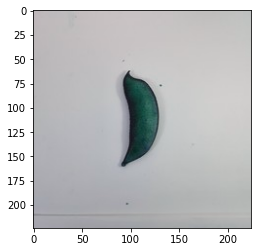

In [16]:
for category in os.listdir('./train'):
    for picture in os.listdir('./train/' + category) :
        img_array = cv2.imread(os.path.join('./train', category, picture))
        plt.imshow(img_array)
        plt.show
        break
    break

Now let us resize the images to a 50x50 format as torch tensors with values between 0 and 1, and save them so we only have to do it once.

In [3]:
img_size = 50
CATEGORIES = ["Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli", "Cabbage", "Capsicum", "Carrot", "Cauliflower", "Cucumber", "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"]


def data_parser(output_file_name, task, CATEGORIES = CATEGORIES, img_size = img_size):
    img_data = torch.tensor([]) # the BIG tensor that will store all our image tensors
    class_data = [] # future tensor which will store our labels
    transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()]) # we resize, then convert to tensor.
    
    for category in CATEGORIES:
        class_number = CATEGORIES.index(category)
        print("parsing ", category)
        
        for picture in os.listdir('./' + task + '/' + category) :            
            img = Image.open(os.path.join('./', task, category, picture))
            img_tensor = transform(img)
            img_data = torch.cat((img_data, img_tensor[None,:]), 0)
            class_data.append(class_number)
            
    print("Converting labels to 1-Hot...") # we convert the labels with a 1-Hot encoding so it is adequate for classification
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(np.array(class_data).reshape(-1, 1))
    class_data = enc.transform(np.array(class_data).reshape(-1, 1)).toarray()
    class_data = torch.tensor(class_data)
    
    print("Saving data...")
    torch.save(img_data, output_file_name + "_" + task + "_values.pt")
    torch.save(class_data, output_file_name + "_" + task + "_labels.pt")
    return "Done."

##### Run this code only the first time :

In [4]:
# data_parser("saved", "train")

In [5]:
images = torch.load(".\saved_train_values.pt")
labels = torch.load(".\saved_train_labels.pt")

Let us now create the dataset as a torch dataset class.

In [6]:
class VeggiesDataset(Dataset):

    def __init__(self, images, labels):

        self.images = torch.tensor(np.array(images))
        self.labels = torch.tensor(np.array(labels))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {'image': self.images[idx], 'label': self.labels[idx]}
        
        return sample

Now let's create our dataset and fit it in a dataloader.

In [7]:
data_train = VeggiesDataset(images, labels)
train_loader = DataLoader(data_train, batch_size = 64, shuffle = True)

It is time to create our convolutional net :

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 11)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 9)
        self.fc1 = nn.Linear(8 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 15)

    def forward(self, x):
        
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


veggie_net = ConvNet()

Select our loss and optimizer :

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(veggie_net.parameters(), lr=0.001, momentum=0.9)

And finally start the training :

In [10]:
epochs = 50

def train(epochs = epochs):

    for epoch in range(epochs): 

        count = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data["image"], data["label"]
            optimizer.zero_grad()

            outputs = veggie_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            count += 1

        print("mean epoch loss for epoch ", epoch + 1, " is ", running_loss/count)

    print('Finished Training')

# Also uncomment below for the first run
# train()

mean epoch loss for epoch  1  is  2.7101308225370047
mean epoch loss for epoch  2  is  2.708609771638686
mean epoch loss for epoch  3  is  2.70641549965697
mean epoch loss for epoch  4  is  2.7000298817688266
mean epoch loss for epoch  5  is  2.598913546117908
mean epoch loss for epoch  6  is  2.079012184304099
mean epoch loss for epoch  7  is  1.8812723877146207
mean epoch loss for epoch  8  is  1.739838672365501
mean epoch loss for epoch  9  is  1.6265595111975915
mean epoch loss for epoch  10  is  1.5352015926004707
mean epoch loss for epoch  11  is  1.4527049705475905
mean epoch loss for epoch  12  is  1.3677959943728084
mean epoch loss for epoch  13  is  1.2917784933624195
mean epoch loss for epoch  14  is  1.2078557456907095
mean epoch loss for epoch  15  is  1.1331248892265513
mean epoch loss for epoch  16  is  1.070154206842842
mean epoch loss for epoch  17  is  1.0190402308537037
mean epoch loss for epoch  18  is  0.9492958065852816
mean epoch loss for epoch  19  is  0.9061096

Now save the model :

In [11]:
torch.save(veggie_net, "veggie_net.pt")

Now we can load it back and test it !

tensor([0.7600, 0.9050, 0.9050, 0.8100, 0.9100, 0.8000, 0.9700, 0.9900, 0.9200,
        0.8850, 0.7450, 0.9400, 0.7750, 0.8800, 0.7400])

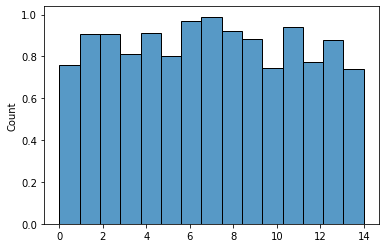

In [12]:
trained_model = torch.load("./veggie_net.pt")
# run parser only first time
# data_parser("saved", "test")

test_images = torch.load(".\saved_test_values.pt")
test_labels = torch.load(".\saved_test_labels.pt")
data_test = VeggiesDataset(test_images, test_labels)
test_loader = DataLoader(data_test, batch_size = 1)
good_predictions = torch.zeros(15)
bad_predictions = torch.zeros(15)
percentage = torch.zeros(15)

for i, data in enumerate(test_loader, 0):

    inputs, labels = data["image"], data["label"]

    outputs = trained_model(inputs)
    predicted_cat = int(torch.argmax(outputs))
    real_cat = int(torch.argmax(labels))
    if predicted_cat == real_cat :
        good_predictions[real_cat] += 1
    else :
        bad_predictions[real_cat] += 1

for k in range(15) :
    percentage[k] = good_predictions[k]/(good_predictions[k] + bad_predictions[k])
    
items = [i for i in range(15)]
sns.histplot(x = items, weights = percentage.detach().numpy(), bins = 15)
percentage

We see the precision for each category above.

We can also do a little guess function to look at a prediction for an individual image.

In [51]:
def guess(image) :
    
    fig, ax = plt.subplots(1, 2)
    
    image_opened = cv2.imread(image)
    image_opened = cv2.cvtColor(image_opened, cv2.COLOR_BGR2RGB)
    img_array = np.array(image_opened)
    ax[0].imshow(img_array)                                                          # show the picture
    ax[0].set_title("initial image")
    
    img = Image.open(image)
    transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()])
    re_img = transform(img)
    s = torch.nn.Softmax(dim = 1)
    res = s(trained_model(re_img[None,:]))                                           # res is the resulting vector probabilities
    
    items = [k for k in range(15)]
    sns.histplot(ax = ax[1], x = items, weights = res[0].detach().numpy(), bins = 15)# plot the probability distribution and
    ax[1].set_title("probability distribution\n over the classes")
    print("I think this is a ", CATEGORIES[int(torch.argmax(res))])                  # the most probable result
    plt.show

and now try some guesses

I think this is a  Carrot


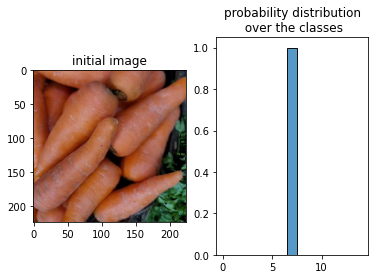

In [52]:
guess('./test/Carrot/1145.jpg')

All good.

I think this is a  Cauliflower


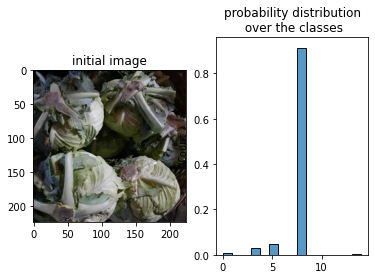

In [53]:
guess('./test/Cabbage/1194.jpg')

Got this one wrong. It's really a tricky Cabbage imge tho... Let's try with a prettier one :

I think this is a  Cabbage


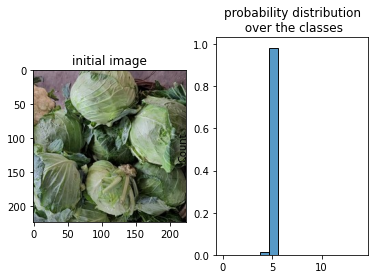

In [54]:
guess('./test/Cabbage/1104.jpg')

Much better. This concludes the little project, all the codes are in the joined files, the dataset is for you to download.